In [67]:
import pandas as pd
import numpy as np

df_origin = pd.read_csv('wimbeldon_dataset_all_surfaces_v2.csv')
df_origin.head()

/var/folders/gv/mb3m1prj1p9_15n7kqzsv6zc0000gn/T/ipykernel_20116/59993403.py:4: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv('wimbeldon_dataset_all_surfaces_v2.csv')


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface
0,2,Chennai,Gold Flake Open,2000-01-03,International,1,3,1st Round,3.0,Agenor R.,...,0.0,0.005319,0.000500,0.004819,1500.0,1500.0,1500.0,1500.0,0.0,0.0
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,1,3,1st Round,3.0,Norman M.,...,0.0,0.003226,0.033333,-0.030108,1500.0,1500.0,1500.0,1500.0,0.0,0.0
2,2,Chennai,Gold Flake Open,2000-01-03,International,1,3,1st Round,3.0,Golmard J.,...,0.0,0.026316,0.002500,0.023816,1500.0,1500.0,1500.0,1500.0,0.0,0.0
3,2,Chennai,Gold Flake Open,2000-01-03,International,1,3,1st Round,3.0,Jonsson F.,...,0.0,0.003937,0.004854,-0.000917,1500.0,1500.0,1500.0,1500.0,0.0,0.0
4,2,Chennai,Gold Flake Open,2000-01-03,International,1,3,1st Round,3.0,Pioline C.,...,0.0,0.035714,0.001208,0.034507,1500.0,1500.0,1500.0,1500.0,0.0,0.0


In [68]:
# Ens tenim que quedar amb només les dades de tots aquests partits que la seva data és anterior al 2025-06-29
df = df_origin.copy()
#df = df_origin[df_origin['Date'] < '2025-06-29'].copy()
df.head()
print("Mida del df: ", len(df))

Mida del df:  69079


In [69]:
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, TimeSeriesSplit

features = [
    'LogRankDiff',      # ranking
    'DiffWR',           # diferencia de winrate históric en herva
    'DiffForm',         # últims 10
    'H2HDiff',          # head-to-head
    'OddsProbDiff',     # diferencia de probabilitat implícita de quotas
    'DiffRest',         # dies de rest
    'EfficiencyDiff',   # winrate / rank → jugador que rendeix per sobre del seu ranking
    'RankDiff',         # diferencia de ranking
    'EloDiff_Global',   # diferencia de elo global
    'EloDiff_Surface'   # diferencia de elo en superfície
]

df = df.sort_values("Date", ascending=True).reset_index(drop=True)

#X_train, X_test, y_train, y_test = train_test_split(df[features], df['WinnerBinary'], test_size=0.2, random_state=42)
X = df[features]
y = df["WinnerBinary"]
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

tscv = TimeSeriesSplit(n_splits=5)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob_model_con_tscv = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob_model_con_tscv)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.6729
Brier Score: 0.2053
              precision    recall  f1-score   support

           0     0.6618    0.6976    0.6793      6859
           1     0.6851    0.6486    0.6663      6957

    accuracy                         0.6729     13816
   macro avg     0.6735    0.6731    0.6728     13816
weighted avg     0.6735    0.6729    0.6727     13816



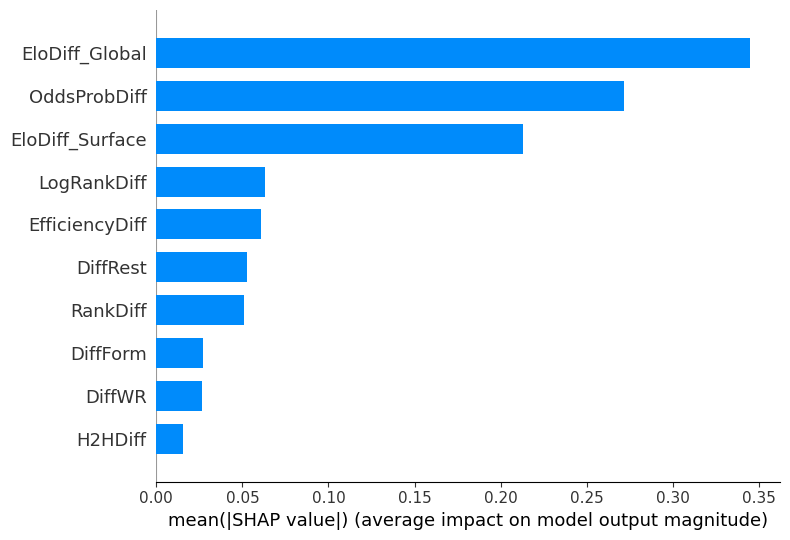

In [70]:
import shap
xgb_model = model.calibrated_classifiers_[0].estimator

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sc)
shap.summary_plot(shap_values, X_train, plot_type="bar")

---

In [71]:
from collections import defaultdict

# ============================
# 1. MAPEO SUPERFICIES SI ESTÁN NUMERIZADAS
# ============================

# Si Surface es numérica (LabelEncoder), necesitamos mapearlo a strings
surface_map = {
    0: "Hard",
    1: "Clay",
    2: "Grass",
    3: "Carpet"
}

# Detectar si Surface es numérica
if np.issubdtype(df["Surface"].dtype, np.number):
    df["SurfaceText"] = df["Surface"].map(surface_map)
else:
    df["SurfaceText"] = df["Surface"]

# ============================
# 2. ORDEN CORRECTO DE RONDAS
# ============================

round_order = {
    "1st Round": 1,
    "2nd Round": 2,
    "3rd Round": 3,
    "4th Round": 4,
    "Round of 16": 5,
    "Quarterfinals": 6,
    "Semifinals": 7,
    "The Final": 8
}

df["RoundOrder"] = df["Round"].map(round_order)

# Ordenar completamente en orden real cronológico
df = df.sort_values(["Date", "Tournament", "RoundOrder"]).reset_index(drop=True)

# ============================
# 3. CONFIGURACIÓN DEL ELO
# ============================

ELO_START = 1500
DECAY_GLOBAL = 0.9995
DECAY_SURFACE = 0.999

def dynamic_k(diff):
    """K depende de diferencia de Elo (más cerca → más grande K)."""
    if diff < 25:
        return 40
    elif diff < 75:
        return 32
    elif diff < 150:
        return 24
    else:
        return 16

# Importancia del torneo
tournament_weights = {
    "ATP250": 1.00,
    "ATP500": 1.10,
    "Masters 1000": 1.20,
    "Grand Slam": 1.30,
    "International": 1.00   # por compatibilidad con tus datos antiguos
}

# ============================
# 4. INICIALIZAR ELO
# ============================

elo_global = defaultdict(lambda: ELO_START)
elo_surface = defaultdict(lambda: {"Hard": ELO_START, "Clay": ELO_START, "Grass": ELO_START, "Carpet": ELO_START})

# Columnas de salida
df["EloA_Global"] = 0.0
df["EloB_Global"] = 0.0
df["EloA_Surface"] = 0.0
df["EloB_Surface"] = 0.0

# ============================
# 5. EXPECTED SCORE
# ============================

def expected_score(r1, r2):
    return 1 / (1 + 10 ** ((r2 - r1) / 400))

# ============================
# 6. CALCULAR ELO SIN DATA LEAKAGE
# ============================

for i, row in df.iterrows():
    
    A = row["PlayerA"]
    B = row["PlayerB"]
    surf = row["SurfaceText"]
    series = row["Series"]

    # --- Decaimiento temporal (antes del partido)
    elo_global[A] *= DECAY_GLOBAL
    elo_global[B] *= DECAY_GLOBAL
    elo_surface[A][surf] *= DECAY_SURFACE
    elo_surface[B][surf] *= DECAY_SURFACE

    # --- Elo ANTES DEL PARTIDO (features pre-partido)
    eloA_g = elo_global[A]
    eloB_g = elo_global[B]
    eloA_s = elo_surface[A][surf]
    eloB_s = elo_surface[B][surf]

    df.at[i, "EloA_Global"] = eloA_g
    df.at[i, "EloB_Global"] = eloB_g
    df.at[i, "EloA_Surface"] = eloA_s
    df.at[i, "EloB_Surface"] = eloB_s

    # --- Resultado del partido
    winner = row["WinnerBinary"]
    scoreA = 1 if winner == 1 else 0
    scoreB = 1 - scoreA

    # --- Expected score
    expA_g = expected_score(eloA_g, eloB_g)
    expA_s = expected_score(eloA_s, eloB_s)

    # --- K dinámico + importancia de torneo
    diff = abs(eloA_g - eloB_g)
    K = dynamic_k(diff)
    weight = tournament_weights.get(series, 1.00)
    K_final = K * weight

    # --- Actualización GLOBAL
    elo_global[A] = eloA_g + K_final * (scoreA - expA_g)
    elo_global[B] = eloB_g + K_final * (scoreB - (1 - expA_g))

    # --- Actualización SUPERFICIE
    elo_surface[A][surf] = eloA_s + K_final * (scoreA - expA_s)
    elo_surface[B][surf] = eloB_s + K_final * (scoreB - (1 - expA_s))

# ============================
# 7. DIFERENCIAS FINALES COMO FEATURES
# ============================

df["EloDiff_Global"] = df["EloA_Global"] - df["EloB_Global"]
df["EloDiff_Surface"] = df["EloA_Surface"] - df["EloB_Surface"]

df.head()


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,1,3,1st Round,3.0,Escude N.,...,0.012500,-0.011737,1499.25,1499.25,1498.5,1498.5,0.0,0.0,Carpet,1.0
1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,1,3,1st Round,3.0,Lisnard J.,...,0.001425,-0.001425,1499.25,1499.25,1498.5,1498.5,0.0,0.0,Carpet,1.0
2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,1,3,1st Round,3.0,Petrovic D.,...,0.002404,0.001695,1499.25,1499.25,1498.5,1498.5,0.0,0.0,Carpet,1.0
3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,1,3,1st Round,3.0,Sekulov J.,...,0.003521,0.002808,1499.25,1499.25,1498.5,1498.5,0.0,0.0,Carpet,1.0
4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,1,3,1st Round,3.0,Gambill J.M.,...,0.000000,0.004762,1499.25,1499.25,1498.5,1498.5,0.0,0.0,Carpet,1.0


---

In [72]:

from sklearn.preprocessing import LabelEncoder

le_series = LabelEncoder()
df["Series"] = le_series.fit_transform(df["Series"])

# ======== FEATURES ========
features = [
    # Diferencias estadísticas base
    'LogRankDiff',
    'DiffWR',
    'DiffForm',
    'H2HDiff',
    'OddsProbDiff',
    'DiffRest',
    'EfficiencyDiff',
    'RankDiff',

    # Elo avanzado
    'EloDiff_Global',
    'EloDiff_Surface',

    # Contexto
    'Series',       # codificada con LabelEncoder
    'RoundOrder'    # orden real de la ronda
]

# Aseguramos orden temporal
df = df.sort_values("Date", ascending=True).reset_index(drop=True)

X = df[features]
y = df["WinnerBinary"].values

n = len(df)
idx_train_end = int(n * 0.7)   # 70% train
idx_val_end   = int(n * 0.8)   # 10% val (70–80)
# 20% restante = test

X_train = X.iloc[:idx_train_end]
y_train = y[:idx_train_end]

X_val   = X.iloc[idx_train_end:idx_val_end]
y_val   = y[idx_train_end:idx_val_end]

X_test  = X.iloc[idx_val_end:]
y_test  = y[idx_val_end:]

print("Tamaños:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# ======== ESCALADO (solo con TRAIN) ========
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

Tamaños:
Train: (48355, 12) Val: (6908, 12) Test: (13816, 12)


In [73]:
from copy import deepcopy

# Valores a probar para número de árboles
n_estimators_grid = [200, 350, 500, 750, 1000, 1300]

results = []

for n_est in n_estimators_grid:
    print(f"\nEntrenando modelo con n_estimators = {n_est}")

    model_tmp = XGBClassifier(
        n_estimators=n_est,
        max_depth=6,
        learning_rate=0.02,
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=5,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        eval_metric="logloss"
    )

    model_tmp.fit(X_train_sc, y_train)

    prob_val = model_tmp.predict_proba(X_val_sc)[:, 1]
    pred_val = (prob_val >= 0.5).astype(int)

    acc_val = accuracy_score(y_val, pred_val)
    brier_val = brier_score_loss(y_val, prob_val)

    results.append((n_est, acc_val, brier_val))
    print(f"VAL → ACC={acc_val:.4f}, BRIER={brier_val:.4f}")

# Elegir el mejor por Brier y, en empate, por accuracy
results_sorted = sorted(results, key=lambda x: (x[2], -x[1]))
best_n, best_acc_val, best_brier_val = results_sorted[0]

print("\n==============================")
print("MEJOR n_estimators EN VALIDACIÓN:")
print(f"n_estimators={best_n}, ACC_VAL={best_acc_val:.4f}, BRIER_VAL={best_brier_val:.4f}")
print("==============================")



Entrenando modelo con n_estimators = 200
VAL → ACC=0.6671, BRIER=0.2070

Entrenando modelo con n_estimators = 350
VAL → ACC=0.6695, BRIER=0.2067

Entrenando modelo con n_estimators = 500
VAL → ACC=0.6702, BRIER=0.2065

Entrenando modelo con n_estimators = 750
VAL → ACC=0.6701, BRIER=0.2068

Entrenando modelo con n_estimators = 1000
VAL → ACC=0.6692, BRIER=0.2070

Entrenando modelo con n_estimators = 1300
VAL → ACC=0.6655, BRIER=0.2076

MEJOR n_estimators EN VALIDACIÓN:
n_estimators=500, ACC_VAL=0.6702, BRIER_VAL=0.2065


In [74]:
# ======== REENTRENAR SCALER EN TRAIN+VAL ========
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = np.concatenate([y_train, y_val])

scaler_final = StandardScaler()
X_train_val_sc = scaler_final.fit_transform(X_train_val)
X_test_sc_final = scaler_final.transform(X_test)

# ======== MODELO XGBOOST FINAL (SIN CALIBRACIÓN) ========
base_model_final = XGBClassifier(
    n_estimators=best_n,
    max_depth=6,
    learning_rate=0.02,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

base_model_final.fit(X_train_val_sc, y_train_val)

# ======== EVALUACIÓN SIN CALIBRACIÓN ========
prob_test_base = base_model_final.predict_proba(X_test_sc_final)[:, 1]
pred_test_base = (prob_test_base >= 0.5).astype(int)

acc_base = accuracy_score(y_test, pred_test_base)
brier_base = brier_score_loss(y_test, prob_test_base)

print("\n===== RESULTADOS SIN CALIBRACIÓN =====")
print(f"Accuracy TEST: {acc_base:.4f}")
print(f"Brier TEST:    {brier_base:.4f}")
print(classification_report(y_test, pred_test_base, digits=4))
print("=======================================")



===== RESULTADOS SIN CALIBRACIÓN =====
Accuracy TEST: 0.6749
Brier TEST:    0.2049
              precision    recall  f1-score   support

           0     0.6675    0.6879    0.6775      6859
           1     0.6827    0.6622    0.6723      6957

    accuracy                         0.6749     13816
   macro avg     0.6751    0.6750    0.6749     13816
weighted avg     0.6752    0.6749    0.6749     13816



In [75]:
# ======== CALIBRACIÓN ISOTÓNICA SOBRE TRAIN+VAL ========
cal_model = CalibratedClassifierCV(
    estimator=deepcopy(base_model_final),
    method="isotonic",
    cv=5
)

cal_model.fit(X_train_val_sc, y_train_val)

prob_test_cal = cal_model.predict_proba(X_test_sc_final)[:, 1]
pred_test_cal = (prob_test_cal >= 0.5).astype(int)

acc_cal = accuracy_score(y_test, pred_test_cal)
brier_cal = brier_score_loss(y_test, prob_test_cal)

print("\n===== RESULTADOS CON CALIBRACIÓN ISOTÓNICA =====")
print(f"Accuracy TEST: {acc_cal:.4f}")
print(f"Brier TEST:    {brier_cal:.4f}")
print(classification_report(y_test, pred_test_cal, digits=4))
print("================================================")



===== RESULTADOS CON CALIBRACIÓN ISOTÓNICA =====
Accuracy TEST: 0.6741
Brier TEST:    0.2049
              precision    recall  f1-score   support

           0     0.6649    0.6924    0.6784      6859
           1     0.6838    0.6560    0.6697      6957

    accuracy                         0.6741     13816
   macro avg     0.6744    0.6742    0.6740     13816
weighted avg     0.6745    0.6741    0.6740     13816



---

In [76]:
from lightgbm import LGBMClassifier

features = [
    # Diferencias estadísticas base
    'LogRankDiff',
    'DiffWR',
    'DiffForm',
    'H2HDiff',
    'OddsProbDiff',
    'DiffRest',
    'EfficiencyDiff',
    'RankDiff',

    # Elo avanzado
    'EloDiff_Global',
    'EloDiff_Surface',

    # Contexto
    'Series',       # codificada con LabelEncoder
    'RoundOrder'    # orden real de la ronda
]

# Aseguramos orden temporal
df = df.sort_values("Date", ascending=True).reset_index(drop=True)

X = df[features]
y = df["WinnerBinary"].values

n = len(df)
idx_train_end = int(n * 0.7)   # 70% train
idx_val_end   = int(n * 0.8)   # +10% val

X_train = X.iloc[:idx_train_end]
y_train = y[:idx_train_end]

X_val   = X.iloc[idx_train_end:idx_val_end]
y_val   = y[idx_train_end:idx_val_end]

X_test  = X.iloc[idx_val_end:]
y_test  = y[idx_val_end:]

print("Tamaños:")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Tamaños:
Train: (48355, 12) Val: (6908, 12) Test: (13816, 12)


In [77]:
param_grid = [
    # (num_leaves, learning_rate, n_estimators, min_data_in_leaf, feature_fraction, bagging_fraction)
    (31,  0.05, 400, 30, 0.9, 0.9),
    (31,  0.03, 800, 30, 0.9, 0.9),
    (63,  0.03, 800, 50, 0.9, 0.9),
    (63,  0.02, 1200, 50, 0.9, 0.8),
    (127, 0.02, 1400, 80, 0.8, 0.8),
]

results = []

for (num_leaves, lr, n_estimators, min_data, feat_frac, bag_frac) in param_grid:
    print(f"\nEntrenando LGBM con: "
          f"num_leaves={num_leaves}, lr={lr}, n_estimators={n_estimators}, "
          f"min_data_in_leaf={min_data}, feature_fraction={feat_frac}, bagging_fraction={bag_frac}")

    lgbm = LGBMClassifier(
        objective='binary',
        num_leaves=num_leaves,
        learning_rate=lr,
        n_estimators=n_estimators,
        min_data_in_leaf=min_data,
        feature_fraction=feat_frac,
        bagging_fraction=bag_frac,
        bagging_freq=1,
        subsample_for_bin=200000,
        random_state=42,
        n_jobs=-1
    )

    lgbm.fit(X_train, y_train)

    prob_val = lgbm.predict_proba(X_val)[:, 1]
    pred_val = (prob_val >= 0.5).astype(int)

    acc_val = accuracy_score(y_val, pred_val)
    brier_val = brier_score_loss(y_val, prob_val)

    results.append({
        "num_leaves": num_leaves,
        "learning_rate": lr,
        "n_estimators": n_estimators,
        "min_data_in_leaf": min_data,
        "feature_fraction": feat_frac,
        "bagging_fraction": bag_frac,
        "acc_val": acc_val,
        "brier_val": brier_val
    })

    print(f"VAL → ACC={acc_val:.4f}, BRIER={brier_val:.4f}")

# Elegir el mejor: minimizamos Brier, y en empate maximizamos ACC
results_sorted = sorted(results, key=lambda r: (r["brier_val"], -r["acc_val"]))
best = results_sorted[0]

print("\n=============== MEJOR CONFIGURACIÓN EN VALIDACIÓN ===============")
print(f"num_leaves={best['num_leaves']}, "
      f"lr={best['learning_rate']}, "
      f"n_estimators={best['n_estimators']}, "
      f"min_data_in_leaf={best['min_data_in_leaf']}, "
      f"feature_fraction={best['feature_fraction']}, "
      f"bagging_fraction={best['bagging_fraction']}")
print(f"ACC_VAL={best['acc_val']:.4f}, BRIER_VAL={best['brier_val']:.4f}")
print("=================================================================")



Entrenando LGBM con: num_leaves=31, lr=0.05, n_estimators=400, min_data_in_leaf=30, feature_fraction=0.9, bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min

In [78]:
# Unimos train + val para entrenar el modelo final
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = np.concatenate([y_train, y_val])

best_lgbm = LGBMClassifier(
    objective='binary',
    num_leaves=best['num_leaves'],
    learning_rate=best['learning_rate'],
    n_estimators=best['n_estimators'],
    min_data_in_leaf=best['min_data_in_leaf'],
    feature_fraction=best['feature_fraction'],
    bagging_fraction=best['bagging_fraction'],
    bagging_freq=1,
    subsample_for_bin=200000,
    random_state=42,
    n_jobs=-1
)

best_lgbm.fit(X_train_val, y_train_val)

# Evaluación en TEST
prob_test = best_lgbm.predict_proba(X_test)[:, 1]
pred_test = (prob_test >= 0.5).astype(int)

acc_test = accuracy_score(y_test, pred_test)
brier_test = brier_score_loss(y_test, prob_test)

print("\n===== RESULTADOS LGBM EN TEST (SIN CALIBRAR) =====")
print(f"Accuracy TEST: {acc_test:.4f}")
print(f"Brier TEST:    {brier_test:.4f}")
print(classification_report(y_test, pred_test, digits=4))
print("==================================================")


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 27995, number of neg

In [79]:
from sklearn.calibration import CalibratedClassifierCV
from copy import deepcopy

cal_lgbm = CalibratedClassifierCV(
    estimator=deepcopy(best_lgbm),
    method="isotonic",
    cv=5
)

cal_lgbm.fit(X_train_val, y_train_val)

prob_test_cal = cal_lgbm.predict_proba(X_test)[:, 1]
pred_test_cal = (prob_test_cal >= 0.5).astype(int)

acc_test_cal = accuracy_score(y_test, pred_test_cal)
brier_test_cal = brier_score_loss(y_test, prob_test_cal)

print("\n===== RESULTADOS LGBM EN TEST (CALIBRADO ISOTÓNICO) =====")
print(f"Accuracy TEST: {acc_test_cal:.4f}")
print(f"Brier TEST:    {brier_test_cal:.4f}")
print(classification_report(y_test, pred_test_cal, digits=4))
print("=========================================================")


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Number of positive: 22396, number of neg

In [80]:
df.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
69074,51,Shanghai,Shanghai Masters,2025-10-10,6,1,3,Quarterfinals,3.0,Medvedev D.,...,0.038809,0.051916,1691.504127,1651.284548,1590.408179,1579.838578,40.219579,10.569601,Carpet,6.0
69075,51,Shanghai,Shanghai Masters,2025-10-10,6,1,3,Quarterfinals,3.0,Rinderknech A.,...,0.008836,0.037754,1634.259004,1554.345741,1546.515563,1446.534097,79.913263,99.981466,Carpet,6.0
69076,51,Shanghai,Shanghai Masters,2025-10-11,6,1,3,Semifinals,3.0,Vacherot V.,...,0.002451,0.164670,1820.576800,1534.866613,1708.158399,1561.914822,285.710187,146.243578,Carpet,7.0
69077,51,Shanghai,Shanghai Masters,2025-10-11,6,1,3,Semifinals,3.0,Rinderknech A.,...,0.008885,0.029954,1671.860940,1571.214670,1598.022873,1463.502294,100.646269,134.520579,Carpet,7.0
69078,51,Shanghai,Shanghai Masters,2025-10-12,6,1,3,The Final,3.0,Vacherot V.,...,0.002640,0.006294,1588.878377,1550.184011,1481.731639,1573.757482,38.694366,-92.025843,Carpet,8.0


---

In [83]:
train = df[df['Date'] < '2025-06-29'].copy()
test = df[(df['Date'] >= '2025-06-29') & (df['Date'] <= '2025-07-13')].copy()
train.tail()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
68190,34,Eastbourne,Eastbourne International,2025-06-27,0,1,2,Semifinals,3.0,Brooksby J.,...,0.026619,-0.022634,1580.340441,1571.101191,1517.798627,1513.089812,9.239250,4.708815,Grass,7.0
68191,35,Mallorca,Mallorca Championships,2025-06-27,0,1,2,Semifinals,3.0,Moutet C.,...,0.005183,0.010843,1500.165431,1469.266775,1536.528132,1509.352359,30.898655,27.175773,Grass,7.0
68192,35,Mallorca,Mallorca Championships,2025-06-27,0,1,2,Semifinals,3.0,Griekspoor T.,...,0.015519,0.006743,1546.282583,1633.460846,1568.580267,1533.644120,-87.178263,34.936147,Grass,7.0
68193,34,Eastbourne,Eastbourne International,2025-06-28,0,1,2,The Final,3.0,Fritz T.,...,0.119915,-0.115902,1599.008808,1672.325062,1535.990054,1634.801117,-73.316253,-98.811062,Grass,8.0
68194,35,Mallorca,Mallorca Championships,2025-06-28,0,1,2,The Final,3.0,Griekspoor T.,...,0.005221,0.010367,1641.690200,1485.942629,1545.299875,1525.074702,155.747571,20.225173,Grass,8.0


In [88]:
print("Mida train: ", len(train))
print("Mida test: ", len(test))


Mida train:  68195
Mida test:  127


In [90]:
# First round 
first_round = test[test['Round'] == '1st Round']
# Second round
second_round = test[test['Round'] == '2nd Round']
# Third round
third_round = test[test['Round'] == '3rd Round']
# Fourth round
fourth_round = test[test['Round'] == '4th Round']
# Quarter finals
quarter_finals = test[test['Round'] == 'Quarterfinals']
# Semi finals
semi_finals = test[test['Round'] == 'Semifinals']
# Finals
finals = test[test['Round'] == 'The Final']

print("Mida first round: ", len(first_round))
print("Mida second round: ", len(second_round))
print("Mida third round: ", len(third_round))
print("Mida fourth round: ", len(fourth_round))
print("Mida quarter finals: ", len(quarter_finals))
print("Mida semi finals: ", len(semi_finals))
print("Mida finals: ", len(finals))



Mida first round:  64
Mida second round:  32
Mida third round:  16
Mida fourth round:  8
Mida quarter finals:  4
Mida semi finals:  2
Mida finals:  1


## First Round

In [103]:
features = [
    # Diferencias estadísticas base
    'LogRankDiff',
    'DiffWR',
    'DiffForm',
    'H2HDiff',
    'OddsProbDiff',
    'DiffRest',
    'EfficiencyDiff',
    'RankDiff',

    # Elo avanzado
    'EloDiff_Global',
    'EloDiff_Surface',

    # Contexto
    'Series',       # codificada con LabelEncoder
    'RoundOrder'    # orden real de la ronda
]

df = df.sort_values("Date", ascending=True).reset_index(drop=True)

X_train = train[features].fillna(0)
X_test = first_round[features].fillna(0)
y_train = train['WinnerBinary']
y_test = first_round['WinnerBinary']

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

tscv = TimeSeriesSplit(n_splits=5)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.6406
Brier Score: 0.2285
              precision    recall  f1-score   support

           0     0.6364    0.6562    0.6462        32
           1     0.6452    0.6250    0.6349        32

    accuracy                         0.6406        64
   macro avg     0.6408    0.6406    0.6405        64
weighted avg     0.6408    0.6406    0.6405        64



In [104]:
from IPython.display import display

def analyze_predictions(
    df,
    y_true,
    y_pred,
    y_prob,
    date_col="Date",
    player_a_col="PlayerA",
    player_b_col="PlayerB",
    true_col_name="WinnerBinary"
):
    """
    Analiza predicciones fila a fila, mostrando:
      - Fecha, jugadores, etiqueta real, predicción, probabilidad
      - Resumen de aciertos/fallos
      - Tabla de predicciones fallidas

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original (por ejemplo, first_round).
    y_true : array-like
        Valores verdaderos (mismo orden que df).
    y_pred : array-like
        Predicciones (0/1) alineadas con y_true.
    y_prob : array-like
        Probabilidad predicha de la clase positiva (mismo orden).
    date_col, player_a_col, player_b_col : str
        Nombres de columnas en df para mostrar contexto.
    true_col_name : str
        Nombre con el que quieres que aparezca la columna de verdad en el output.

    Returns
    -------
    results_df : pd.DataFrame
        DataFrame con todas las filas y columnas extra (Predicted, Probability, Correct, Result).
    failed_df : pd.DataFrame
        Subconjunto con solo las predicciones fallidas.
    """

    # Copia de las columnas de contexto
    results_df = df[[date_col, player_a_col, player_b_col]].copy()
    results_df[true_col_name] = y_true

    # Añadir predicciones y probabilidades
    results_df["Predicted"] = y_pred
    results_df["Probability"] = y_prob

    # Aciertos / fallos
    results_df["Correct"] = (results_df[true_col_name] == results_df["Predicted"])
    results_df["Result"] = results_df["Correct"].map({True: "✓ Correct", False: "✗ Failed"})

    # Resumen global
    total = len(results_df)
    correct = results_df["Correct"].sum()
    incorrect = total - correct
    acc = correct / total if total > 0 else 0.0

    print("RESULTADOS DETALLADOS POR FILA:")
    print("=" * 100)
    print(f"\nTotal de predicciones: {total}")
    print(f"Correctas: {correct} ({acc*100:.2f}%)")
    print(f"Fallidas: {incorrect} ({(1-acc)*100:.2f}%)")
    print("\n" + "=" * 100 + "\n")

    # Mostrar todas las filas
    pd.set_option("display.max_rows", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_columns", None)

    display(results_df[[date_col, player_a_col, player_b_col,
                        true_col_name, "Predicted", "Probability", "Result"]])

    # Mostrar solo fallos
    print("\n" + "=" * 100)
    print("PREDICCIONES FALLIDAS:")
    print("=" * 100)
    failed_df = results_df[~results_df["Correct"]]

    if len(failed_df) > 0:
        display(failed_df[[date_col, player_a_col, player_b_col,
                           true_col_name, "Predicted", "Probability"]])
    else:
        print("¡Todas las predicciones han sido correctas!")

    return results_df, failed_df

In [105]:
results_df, failed_df = analyze_predictions(
    df=first_round,
    y_true=first_round["WinnerBinary"].values,
    y_pred=pred,
    y_prob=prob,
    date_col="Date",
    player_a_col="PlayerA",
    player_b_col="PlayerB",
    true_col_name="WinnerBinary"
)

RESULTADOS DETALLADOS POR FILA:

Total de predicciones: 64
Correctas: 41 (64.06%)
Fallidas: 23 (35.94%)




,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability,Result
68195,2025-06-30,Kopriva V.,Thompson J.,0,0,0.268098,✓ Correct
68196,2025-06-30,Fery A.,Popyrin A.,1,0,0.275337,✗ Failed
68197,2025-06-30,Quinn E.,Searle H.,1,1,0.685398,✓ Correct
68198,2025-06-30,Jarry N.,Rune H.,1,0,0.240102,✗ Failed
68199,2025-06-30,Misolic F.,Struff J.L.,0,0,0.360912,✓ Correct
68200,2025-06-30,Bellucci M.,Crawford O.,1,1,0.751155,✓ Correct
68201,2025-06-30,Garin C.,Rodesch C.,1,0,0.484618,✗ Failed
68202,2025-06-30,Borges N.,Cerundolo F.,1,0,0.429620,✗ Failed
68203,2025-06-30,Davidovich Fokina A.,Holt B.,1,1,0.795220,✓ Correct
68204,2025-06-30,Darderi L.,Safiullin R.,1,0,0.266239,✗ Failed



PREDICCIONES FALLIDAS:


,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability
68196,2025-06-30,Fery A.,Popyrin A.,1,0,0.275337
68198,2025-06-30,Jarry N.,Rune H.,1,0,0.240102
68201,2025-06-30,Garin C.,Rodesch C.,1,0,0.484618
68202,2025-06-30,Borges N.,Cerundolo F.,1,0,0.429620
68204,2025-06-30,Darderi L.,Safiullin R.,1,0,0.266239
68205,2025-06-30,Berrettini M.,Majchrzak K.,0,1,0.897215
68208,2025-06-30,Bergs Z.,Harris L.,0,1,0.744967
68210,2025-06-30,Royer V.,Tsitsipas S.,1,0,0.265524
68212,2025-06-30,Brooksby J.,Griekspoor T.,1,0,0.356450
68213,2025-06-30,Bonzi B.,Medvedev D.,1,0,0.069562


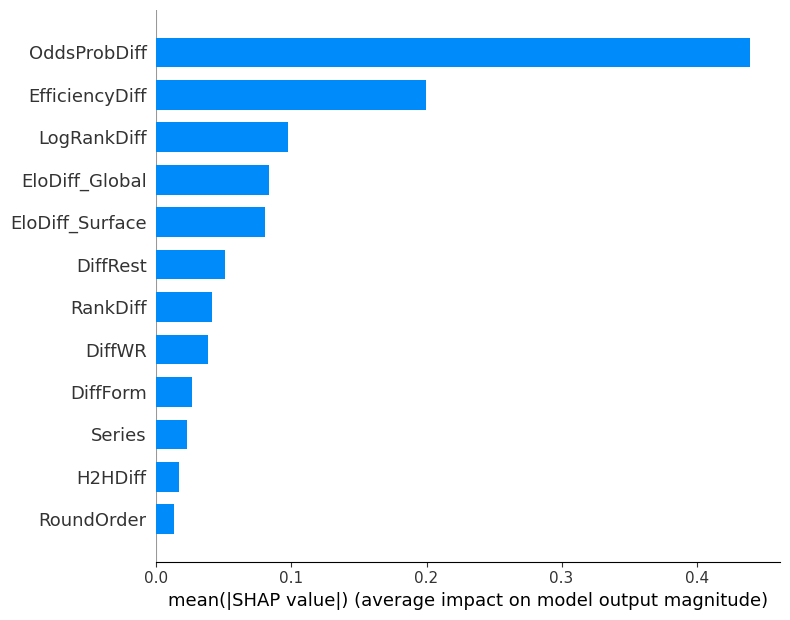

In [101]:
import shap

xgb_model = model.calibrated_classifiers_[0].estimator

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_sc)
shap.summary_plot(shap_values, X_train, plot_type="bar")

---

## Second Round

In [106]:
# Actualizar el conjunt de entrenament: afegir first_round al train actual
train_second_round = pd.concat([first_round, train], ignore_index=True)

print(f"Mida del train original: {len(train_second_round) - len(first_round)}")
print(f"Mida de first_round afegir: {len(first_round)}")
print(f"Mida del nou train: {len(train_second_round)}")
print(f"\nTrain actualizat correctament. Llest per la següent fase.")

train_second_round.head()

Mida del train original: 68195
Mida de first_round afegir: 64
Mida del nou train: 68259

Train actualizat correctament. Llest per la següent fase.


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL,MaxWin,MaxLoss,AvgWin,AvgLoss,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary,MaxOddsPlayerA,MaxOddsPlayerB,AvgOddsPlayerA,AvgOddsPlayerB,H2H_A_wins,H2H_B_wins,H2H_Diff,WinsA,LossesA,WinsB,LossesB,WinRateA_cum,WinRateB_cum,Form10A,Form10B,RestDaysA,RestDaysB,DiffWR,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
0,36,London,Wimbledon,2025-06-30,2,1,2,1st Round,5.0,Thompson J.,Kopriva V.,44.0,78.0,3.0,6.0,4.0,6.0,6.0,3.0,7.0,6.0,6.0,1.0,3.0,2.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.40,3.00,NaN,NaN,NaN,NaN,1.43,3.03,1200.0,757.0,NaN,NaN,NaN,NaN,NaN,NaN,1.43,3.35,1.38,3.02,NaN,NaN,1.43,3.03,1.415,3.015,Kopriva V.,Thompson J.,78.0,44.0,34.0,0,3.35,1.43,3.02,1.38,0,0,0,10,15,144,165,0.400000,0.466019,0.5,0.3,33,13,-0.066019,0.2,20,0.572519,0,0.298507,0.699301,-0.400793,0.005128,0.010591,-0.005463,1435.991656,1514.516010,1494.145626,1495.763161,-78.524353,-1.617535,Grass,1.0
1,36,London,Wimbledon,2025-06-30,2,1,2,1st Round,5.0,Fery A.,Popyrin A.,461.0,22.0,6.0,4.0,6.0,1.0,4.0,6.0,6.0,4.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.33,1.22,NaN,NaN,NaN,NaN,4.45,1.24,91.0,2140.0,NaN,NaN,NaN,NaN,NaN,NaN,4.50,1.28,4.02,1.24,NaN,NaN,4.45,1.24,4.390,1.230,Fery A.,Popyrin A.,461.0,22.0,439.0,1,4.50,1.28,4.02,1.24,0,0,0,0,2,100,122,0.000000,0.450450,0.0,0.6,364,12,-0.450450,-0.6,352,3.042356,0,0.222222,0.781250,-0.559028,0.000000,0.020475,-0.020475,1472.593945,1530.845391,1468.318148,1415.915885,-58.251446,52.402263,Grass,1.0
2,36,London,Wimbledon,2025-06-30,2,1,2,1st Round,5.0,Quinn E.,Searle H.,89.0,421.0,4.0,6.0,6.0,2.0,7.0,6.0,6.0,2.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.44,2.80,NaN,NaN,NaN,NaN,1.47,2.85,682.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,1.48,2.94,1.44,2.75,NaN,NaN,1.47,2.85,1.455,2.825,Quinn E.,Searle H.,89.0,421.0,-332.0,1,1.48,2.94,1.44,2.75,0,0,0,8,16,0,2,0.333333,0.000000,0.4,0.0,6,363,0.333333,0.4,-357,-1.553996,0,0.675676,0.340136,0.335540,0.003745,0.000000,0.003745,1441.475374,1455.118417,1501.137976,1457.990153,-13.643043,43.147824,Grass,1.0
3,36,London,Wimbledon,2025-06-30,2,1,2,1st Round,5.0,Jarry N.,Rune H.,143.0,8.0,4.0,6.0,4.0,6.0,7.0,5.0,6.0,3.0,6.0,4.0,3.0,2.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.75,1.29,NaN,NaN,NaN,NaN,3.76,1.30,418.0,3530.0,NaN,NaN,NaN,NaN,NaN,NaN,4.00,1.32,3.65,1.28,NaN,NaN,3.76,1.30,3.755,1.295,Jarry N.,Rune H.,143.0,8.0,135.0,1,4.00,1.32,3.65,1.28,0,1,-1,105,110,157,93,0.488372,0.628000,0.3,0.6,18,10,-0.139628,-0.3,8,2.883403,-1,0.250000,0.757576,-0.507576,0.003415,0.078500,-0.075085,1429.372274,1674.031106,1439.398085,1526.815285,-244.658832,-87.417200,Grass,1.0
4,36,London,Wimbledon,2025-06-30,2,1,2,1st Round,5.0,Struff J.L.,Misolic F.,125.0,111.0,6.0,2.0,5.0,7.0,6.0,3.0,6.0,3.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.67,2.25,NaN,NaN,NaN,NaN,1.65,2.36,475.0,518.0,NaN,NaN,NaN,NaN,NaN,NaN,1.68,2.40,1.62,2.28,NaN,NaN,1.67,2.36,1.660,2.305,Misolic F.,Struff J.L.,111.0,125.0,-14.0,0,2.40,1.68,2.28,1.62,0,0,0,12,11,206,241,0.521739,0.460850,0.5,0.2,30,13,0.060889,0.3,17,-0.118784,0,0.416667,0.595238,-0.178571,0.004700,0.003687,0.001014,1483.741386,1413.543282,1498.500000,1493.836790,70.198104,4.663210,Grass,1.0


In [107]:
X_train = train_second_round[features].fillna(0)
X_test = second_round[features].fillna(0)
y_train = train_second_round['WinnerBinary']
y_test = second_round['WinnerBinary']

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.6875
Brier Score: 0.2218
              precision    recall  f1-score   support

           0     0.5556    0.8333    0.6667        12
           1     0.8571    0.6000    0.7059        20

    accuracy                         0.6875        32
   macro avg     0.7063    0.7167    0.6863        32
weighted avg     0.7440    0.6875    0.6912        32



In [ ]:
results_df, failed_df = analyze_predictions(
    df=second_round,
    y_true=second_round["WinnerBinary"].values,
    y_pred=pred,
    y_prob=prob,
    date_col="Date",
    player_a_col="PlayerA",
    player_b_col="PlayerB",
    true_col_name="WinnerBinary"
)

RESULTADOS DETALLADOS POR FILA:

Total de predicciones: 32
Correctas: 22 (68.75%)
Fallidas: 10 (31.25%)




,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability,Result
68258,2025-07-02,Khachanov K.,Mochizuki S.,1,1,0.880638,✓ Correct
68259,2025-07-02,Diallo G.,Fritz T.,0,0,0.221491,✓ Correct
68260,2025-07-02,Borges N.,Harris B.,1,1,0.584241,✓ Correct
68261,2025-07-02,Jarry N.,Tien L.,1,1,0.537511,✓ Correct
68263,2025-07-02,Norrie C.,Tiafoe F.,1,0,0.421631,✗ Failed
68264,2025-07-02,Bonzi B.,Thompson J.,0,1,0.586356,✗ Failed
68265,2025-07-02,Alcaraz C.,Tarvet O.,1,1,0.933136,✓ Correct
68266,2025-07-02,Brooksby J.,Fonseca J.,0,0,0.354561,✓ Correct
68267,2025-07-02,Bellucci M.,Lehecka J.,1,0,0.200418,✗ Failed
68268,2025-07-02,Mannarino A.,Royer V.,1,1,0.715499,✓ Correct



PREDICCIONES FALLIDAS:


,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability
68263,2025-07-02,Norrie C.,Tiafoe F.,1,0,0.421631
68264,2025-07-02,Bonzi B.,Thompson J.,0,1,0.586356
68267,2025-07-02,Bellucci M.,Lehecka J.,1,0,0.200418
68270,2025-07-02,Majchrzak K.,Quinn E.,1,0,0.452083
68271,2025-07-03,Martinez P.,Navone M.,1,0,0.407297
68275,2025-07-03,Cilic M.,Draper J.,1,0,0.167210
68277,2025-07-03,Auger-Aliassime F.,Struff J.L.,0,1,0.745191
68278,2025-07-03,Ofner S.,Paul T.,1,0,0.133531
68279,2025-07-03,Holmgren A.,Machac T.,1,0,0.136344
68291,2025-07-04,Fucsovics M.,Monfils G.,1,0,0.466084


---

## Third Round

In [109]:
# Actualizar el conjunto de entrenamiento: añadir first_round al train actual
train_third_round = pd.concat([second_round, train_second_round], ignore_index=True)

print(f"Tamaño del train original: {len(train_third_round) - len(second_round)}")
print(f"Tamaño de first_round añadido: {len(second_round)}")
print(f"Tamaño del nuevo train: {len(train_third_round)}")
print(f"\nTrain actualizado correctamente. Listo para la siguiente fase.")

train_third_round.head()

Tamaño del train original: 68259
Tamaño de first_round añadido: 32
Tamaño del nuevo train: 68291

Train actualizado correctamente. Listo para la siguiente fase.


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL,MaxWin,MaxLoss,AvgWin,AvgLoss,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary,MaxOddsPlayerA,MaxOddsPlayerB,AvgOddsPlayerA,AvgOddsPlayerB,H2H_A_wins,H2H_B_wins,H2H_Diff,WinsA,LossesA,WinsB,LossesB,WinRateA_cum,WinRateB_cum,Form10A,Form10B,RestDaysA,RestDaysB,DiffWR,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
0,36,London,Wimbledon,2025-07-02,2,1,2,2nd Round,5.0,Khachanov K.,Mochizuki S.,20.0,144.0,1.0,6.0,7.0,6.0,4.0,6.0,6.0,3.0,6.0,4.0,3.0,2.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.14,5.50,NaN,NaN,NaN,NaN,1.14,6.76,2240.0,413.0,NaN,NaN,NaN,NaN,NaN,NaN,1.16,7.00,1.13,5.81,NaN,NaN,1.14,6.76,1.140,6.13,Khachanov K.,Mochizuki S.,20.0,144.0,-124.0,1,1.16,7.00,1.13,5.81,0,0,0,284,205,4,16,0.580777,0.200000,0.7,0.2,2,1,0.380777,0.5,1,-1.974081,0,0.862069,0.142857,0.719212,0.029039,0.001389,0.027650,1599.013330,1350.351456,1558.723048,1465.261433,248.661874,93.461615,Grass,2.0
1,36,London,Wimbledon,2025-07-02,2,1,2,2nd Round,5.0,Fritz T.,Diallo G.,5.0,40.0,3.0,6.0,6.0,3.0,7.0,6.0,4.0,6.0,6.0,3.0,3.0,2.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30,3.60,NaN,NaN,NaN,NaN,1.32,3.76,4635.0,1322.0,NaN,NaN,NaN,NaN,NaN,NaN,1.36,3.90,1.30,3.50,NaN,NaN,1.32,3.76,1.310,3.68,Diallo G.,Fritz T.,40.0,5.0,35.0,0,3.90,1.36,3.50,1.30,0,0,0,26,23,285,189,0.530612,0.601266,0.8,0.9,2,1,-0.070654,-0.1,1,2.079442,0,0.256410,0.735294,-0.478884,0.013265,0.120253,-0.106988,1579.481871,1687.476858,1528.176432,1648.849603,-107.994986,-120.673171,Grass,2.0
2,36,London,Wimbledon,2025-07-02,2,1,2,2nd Round,5.0,Borges N.,Harris B.,37.0,151.0,6.0,3.0,6.0,4.0,7.0,6.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.53,2.50,NaN,NaN,NaN,NaN,1.58,2.56,1400.0,383.0,NaN,NaN,NaN,NaN,NaN,NaN,1.60,2.62,1.56,2.40,NaN,NaN,1.58,2.56,1.555,2.53,Borges N.,Harris B.,37.0,151.0,-114.0,1,1.60,2.62,1.56,2.40,0,0,0,57,64,10,11,0.471074,0.476190,0.6,0.3,2,2,-0.005116,0.3,0,-1.406362,0,0.625000,0.381679,0.243321,0.012732,0.003154,0.009578,1523.867714,1462.128763,1447.222082,1526.381429,61.738951,-79.159346,Grass,2.0
3,36,London,Wimbledon,2025-07-02,2,1,2,2nd Round,5.0,Jarry N.,Tien L.,143.0,62.0,6.0,2.0,6.0,2.0,6.0,3.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.67,2.20,NaN,NaN,NaN,NaN,1.76,2.20,418.0,940.0,NaN,NaN,NaN,NaN,NaN,NaN,1.77,2.24,1.68,2.18,NaN,NaN,1.76,2.20,1.715,2.20,Jarry N.,Tien L.,143.0,62.0,81.0,1,1.77,2.24,1.68,2.18,0,0,0,106,110,14,18,0.490741,0.437500,0.4,0.5,2,2,0.053241,-0.1,0,0.835710,0,0.564972,0.446429,0.118543,0.003432,0.007056,-0.003625,1445.362211,1470.563932,1450.908581,1513.345983,-25.201721,-62.437401,Grass,2.0
4,36,London,Wimbledon,2025-07-02,2,1,2,2nd Round,5.0,Norrie C.,Tiafoe F.,61.0,12.0,4.0,6.0,6.0,4.0,6.0,3.0,7.0,5.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.50,1.53,NaN,NaN,NaN,NaN,2.59,1.57,952.0,2990.0,NaN,NaN,NaN,NaN,NaN,NaN,2.66,1.59,2.48,1.54,NaN,NaN,2.59,1.57,2.545,1.55,Norrie C.,Tiafoe F.,61.0,12.0,49.0,1,2.66,1.59,2.48,1.54,1,2,-1,213,156,215,191,0.577236,0.529557,0.6,0.6,2,2,0.047679,0.0,0,1.625967,-1,0.375940,0.628931,-0.252991,0.009463,0.044130,-0.034667,1560.888436,1553.980573,1516.736659,1528.145373,6.907863,-11.408714,Grass,2.0


In [110]:
X_train = train_third_round[features].fillna(0)
X_test = third_round[features].fillna(0)
y_train = train_third_round['WinnerBinary']
y_test = third_round['WinnerBinary']

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.7500
Brier Score: 0.1413
              precision    recall  f1-score   support

           0     0.7778    0.7778    0.7778         9
           1     0.7143    0.7143    0.7143         7

    accuracy                         0.7500        16
   macro avg     0.7460    0.7460    0.7460        16
weighted avg     0.7500    0.7500    0.7500        16



In [112]:
results_df, failed_df = analyze_predictions(
    df=third_round,
    y_true=third_round["WinnerBinary"].values,
    y_pred=pred,
    y_prob=prob,
    date_col="Date",
    player_a_col="PlayerA",
    player_b_col="PlayerB",
    true_col_name="WinnerBinary"
)

RESULTADOS DETALLADOS POR FILA:

Total de predicciones: 16
Correctas: 12 (75.00%)
Fallidas: 4 (25.00%)




,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability,Result
68289,2025-07-04,Mannarino A.,Rublev A.,0,0,0.288673,✓ Correct
68290,2025-07-04,Majchrzak K.,Rinderknech A.,1,0,0.474551,✗ Failed
68293,2025-07-04,Borges N.,Khachanov K.,0,0,0.288052,✓ Correct
68294,2025-07-04,Bellucci M.,Norrie C.,0,0,0.383733,✓ Correct
68295,2025-07-04,Alcaraz C.,Struff J.L.,1,1,0.948323,✓ Correct
68296,2025-07-04,Davidovich Fokina A.,Fritz T.,0,0,0.234247,✓ Correct
68297,2025-07-04,Darderi L.,Thompson J.,0,0,0.453224,✓ Correct
68298,2025-07-04,Fonseca J.,Jarry N.,0,1,0.710543,✗ Failed
68299,2025-07-05,Cilic M.,Munar J.,1,1,0.735884,✓ Correct
68300,2025-07-05,Djokovic N.,Kecmanovic M.,1,1,0.964464,✓ Correct



PREDICCIONES FALLIDAS:


,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability
68290,2025-07-04,Majchrzak K.,Rinderknech A.,1,0,0.474551
68298,2025-07-04,Fonseca J.,Jarry N.,0,1,0.710543
68304,2025-07-05,Cobolli F.,Mensik J.,1,0,0.445961
68306,2025-07-05,Nakashima B.,Sonego L.,0,1,0.625038


--- 

## Fourth Round

In [113]:
# Actualizar el conjunto de entrenamiento: añadir first_round al train actual
train_fourth_round = pd.concat([third_round, train_third_round], ignore_index=True)

print(f"Tamaño del train original: {len(train_fourth_round) - len(third_round)}")
print(f"Tamaño de first_round añadido: {len(third_round)}")
print(f"Tamaño del nuevo train: {len(train_fourth_round)}")
print(f"\nTrain actualizado correctamente. Listo para la siguiente fase.")

train_fourth_round.head()

Tamaño del train original: 68291
Tamaño de first_round añadido: 16
Tamaño del nuevo train: 68307

Train actualizado correctamente. Listo para la siguiente fase.


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL,MaxWin,MaxLoss,AvgWin,AvgLoss,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary,MaxOddsPlayerA,MaxOddsPlayerB,AvgOddsPlayerA,AvgOddsPlayerB,H2H_A_wins,H2H_B_wins,H2H_Diff,WinsA,LossesA,WinsB,LossesB,WinRateA_cum,WinRateB_cum,Form10A,Form10B,RestDaysA,RestDaysB,DiffWR,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
0,36,London,Wimbledon,2025-07-04,2,1,2,3rd Round,5.0,Rublev A.,Mannarino A.,14.0,123.0,7.0,5.0,6.0,2.0,6.0,3.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.25,3.75,NaN,NaN,NaN,NaN,1.30,3.96,2920.0,477.0,NaN,NaN,NaN,NaN,NaN,NaN,1.31,4.10,1.27,3.77,NaN,NaN,1.30,3.96,1.275,3.855,Mannarino A.,Rublev A.,123.0,14.0,109.0,0,4.10,1.31,3.77,1.27,1,3,-2,298,344,336,188,0.464174,0.641221,0.4,0.7,2,2,-0.177047,-0.3,0,2.173127,-2,0.243902,0.763359,-0.519456,0.003774,0.045802,-0.042028,1412.322544,1600.606579,1545.683690,1554.029660,-188.284035,-8.345970,Grass,3.0
1,36,London,Wimbledon,2025-07-04,2,1,2,3rd Round,5.0,Majchrzak K.,Rinderknech A.,109.0,72.0,6.0,3.0,7.0,6.0,7.0,6.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.91,1.90,NaN,NaN,NaN,NaN,2.07,1.85,527.0,873.0,NaN,NaN,NaN,NaN,NaN,NaN,2.10,1.90,2.00,1.80,NaN,NaN,2.07,1.90,1.990,1.875,Majchrzak K.,Rinderknech A.,109.0,72.0,37.0,1,2.10,1.90,2.00,1.80,0,0,0,24,35,81,95,0.406780,0.460227,0.5,0.6,2,1,-0.053448,-0.1,1,0.414682,0,0.476190,0.526316,-0.050125,0.003732,0.006392,-0.002660,1441.038574,1468.420628,1500.291002,1482.169575,-27.382054,18.121427,Grass,3.0
2,36,London,Wimbledon,2025-07-04,2,1,2,3rd Round,5.0,Khachanov K.,Borges N.,20.0,37.0,7.0,6.0,4.0,6.0,4.0,6.0,6.0,3.0,7.0,6.0,3.0,2.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.40,3.00,NaN,NaN,NaN,NaN,1.44,3.03,2240.0,1400.0,NaN,NaN,NaN,NaN,NaN,NaN,1.48,3.05,1.41,2.89,NaN,NaN,1.44,3.03,1.420,3.015,Borges N.,Khachanov K.,37.0,20.0,17.0,0,3.05,1.48,2.89,1.41,0,1,-1,58,64,285,205,0.475410,0.581633,0.6,0.7,2,2,-0.106223,-0.1,0,0.615186,-1,0.327869,0.675676,-0.347807,0.012849,0.029082,-0.016233,1540.239490,1602.223693,1471.208116,1564.824598,-61.984204,-93.616482,Grass,3.0
3,36,London,Wimbledon,2025-07-04,2,1,2,3rd Round,5.0,Norrie C.,Bellucci M.,61.0,73.0,7.0,6.0,6.0,4.0,6.0,3.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.57,2.30,NaN,NaN,NaN,NaN,1.60,2.50,952.0,864.0,NaN,NaN,NaN,NaN,NaN,NaN,1.63,2.56,1.56,2.41,NaN,NaN,1.60,2.50,1.585,2.400,Bellucci M.,Norrie C.,73.0,61.0,12.0,0,2.56,1.63,2.41,1.56,0,0,0,15,19,214,156,0.441176,0.578378,0.4,0.6,2,2,-0.137202,-0.2,0,0.179586,0,0.390625,0.613497,-0.222872,0.006044,0.009482,-0.003438,1471.831789,1585.578375,1493.135817,1542.046522,-113.746586,-48.910705,Grass,3.0
4,36,London,Wimbledon,2025-07-04,2,1,2,3rd Round,5.0,Alcaraz C.,Struff J.L.,2.0,125.0,6.0,1.0,3.0,6.0,6.0,3.0,6.0,4.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,11.00,NaN,NaN,NaN,NaN,1.05,15.53,9300.0,475.0,NaN,NaN,NaN,NaN,NaN,NaN,1.05,18.00,1.03,12.61,NaN,NaN,1.05,15.53,1.045,13.265,Alcaraz C.,Struff J.L.,2.0,125.0,-123.0,1,1.05,18.00,1.03,12.61,3,1,2,236,59,208,241,0.800000,0.463252,1.0,0.4,2,1,0.336748,0.6,1,-4.135167,2,0.952381,0.055556,0.896825,0.400000,0.003706,0.396294,1922.092396,1457.114874,1727.158193,1529.553850,464.977522,197.604343,Grass,3.0


In [114]:
X_train = train_fourth_round[features].fillna(0)
X_test = fourth_round[features].fillna(0)
y_train = train_fourth_round['WinnerBinary']
y_test = fourth_round['WinnerBinary']

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.8750
Brier Score: 0.0792
              precision    recall  f1-score   support

           0     1.0000    0.7500    0.8571         4
           1     0.8000    1.0000    0.8889         4

    accuracy                         0.8750         8
   macro avg     0.9000    0.8750    0.8730         8
weighted avg     0.9000    0.8750    0.8730         8



In [117]:
results_df, failed_df = analyze_predictions(
    df=fourth_round,
    y_true=fourth_round["WinnerBinary"].values,
    y_pred=pred,
    y_prob=prob,
    date_col="Date",
    player_a_col="PlayerA",
    player_b_col="PlayerB",
    true_col_name="WinnerBinary"
)

RESULTADOS DETALLADOS POR FILA:

Total de predicciones: 8
Correctas: 7 (87.50%)
Fallidas: 1 (12.50%)




,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability,Result
68307,2025-07-06,Fritz T.,Thompson J.,1,1,0.884897,✓ Correct
68308,2025-07-06,Jarry N.,Norrie C.,0,0,0.386972,✓ Correct
68309,2025-07-06,Khachanov K.,Majchrzak K.,1,1,0.725209,✓ Correct
68310,2025-07-06,Alcaraz C.,Rublev A.,1,1,0.915370,✓ Correct
68311,2025-07-07,Cilic M.,Cobolli F.,0,1,0.549291,✗ Failed
68312,2025-07-07,Shelton B.,Sonego L.,1,1,0.744875,✓ Correct
68313,2025-07-07,Dimitrov G.,Sinner J.,0,0,0.057033,✓ Correct
68314,2025-07-07,De Minaur A.,Djokovic N.,0,0,0.133952,✓ Correct



PREDICCIONES FALLIDAS:


,Date,PlayerA,PlayerB,WinnerBinary,Predicted,Probability
68311,2025-07-07,Cilic M.,Cobolli F.,0,1,0.549291


---

## Quarter Finals

In [118]:
# Actualizar el conjunto de entrenamiento: añadir first_round al train actual
train_quarter_finals = pd.concat([fourth_round, train_fourth_round], ignore_index=True)

print(f"Tamaño del train original: {len(train_quarter_finals) - len(fourth_round)}")
print(f"Tamaño de first_round añadido: {len(fourth_round)}")
print(f"Tamaño del nuevo train: {len(train_quarter_finals)}")
print(f"\nTrain actualizado correctamente. Listo para la siguiente fase.")

train_quarter_finals.head()

Tamaño del train original: 68307
Tamaño de first_round añadido: 8
Tamaño del nuevo train: 68315

Train actualizado correctamente. Listo para la siguiente fase.


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL,MaxWin,MaxLoss,AvgWin,AvgLoss,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary,MaxOddsPlayerA,MaxOddsPlayerB,AvgOddsPlayerA,AvgOddsPlayerB,H2H_A_wins,H2H_B_wins,H2H_Diff,WinsA,LossesA,WinsB,LossesB,WinRateA_cum,WinRateB_cum,Form10A,Form10B,RestDaysA,RestDaysB,DiffWR,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
0,36,London,Wimbledon,2025-07-06,2,1,2,4th Round,5.0,Fritz T.,Thompson J.,5.0,44.0,6.0,1.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Retired,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.14,5.50,NaN,NaN,NaN,NaN,1.15,6.36,4635.0,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.16,6.80,1.14,5.64,NaN,NaN,1.15,6.36,1.145,5.930,Fritz T.,Thompson J.,5.0,44.0,-39.0,1,1.16,6.80,1.14,5.64,1,1,0,287,189,147,165,0.602941,0.471154,0.9,0.5,2,2,0.131787,0.4,0,-2.174752,0,0.862069,0.147059,0.715010,0.120588,0.010708,0.109880,1707.852520,1550.642850,1664.423582,1538.487318,157.209671,125.936264,Grass,4.0
1,36,London,Wimbledon,2025-07-06,2,1,2,4th Round,5.0,Norrie C.,Jarry N.,61.0,143.0,6.0,3.0,7.0,6.0,6.0,7.0,6.0,7.0,6.0,3.0,3.0,2.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,1.91,NaN,NaN,NaN,NaN,1.87,2.04,952.0,418.0,NaN,NaN,NaN,NaN,NaN,NaN,2.10,2.08,1.84,1.96,NaN,NaN,1.87,2.04,1.850,1.975,Jarry N.,Norrie C.,143.0,61.0,82.0,0,2.08,2.10,1.96,1.84,1,0,1,108,110,215,156,0.495413,0.579515,0.5,0.6,2,2,-0.084102,-0.1,0,0.851971,1,0.480769,0.476190,0.004579,0.003464,0.009500,-0.006036,1486.922241,1595.447958,1489.777273,1553.909340,-108.525717,-64.132067,Grass,4.0
2,36,London,Wimbledon,2025-07-06,2,1,2,4th Round,5.0,Khachanov K.,Majchrzak K.,20.0,109.0,6.0,4.0,6.0,2.0,6.0,3.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36,3.20,NaN,NaN,NaN,NaN,1.38,3.36,2240.0,527.0,NaN,NaN,NaN,NaN,NaN,NaN,1.40,3.40,1.35,3.19,NaN,NaN,1.38,3.36,1.370,3.280,Khachanov K.,Majchrzak K.,20.0,109.0,-89.0,1,1.40,3.40,1.35,3.19,3,0,3,286,205,25,35,0.582485,0.416667,0.7,0.6,2,2,0.165818,0.1,0,-1.695616,3,0.714286,0.294118,0.420168,0.029124,0.003823,0.025302,1618.542071,1462.742738,1578.571698,1518.487098,155.799333,60.084600,Grass,4.0
3,36,London,Wimbledon,2025-07-06,2,1,2,4th Round,5.0,Alcaraz C.,Rublev A.,2.0,14.0,6.0,7.0,6.0,3.0,6.0,4.0,6.0,4.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.08,7.00,NaN,NaN,NaN,NaN,1.10,8.57,9300.0,2920.0,NaN,NaN,NaN,NaN,NaN,NaN,1.11,9.40,1.09,7.50,NaN,NaN,1.10,8.57,1.090,7.785,Alcaraz C.,Rublev A.,2.0,14.0,-12.0,1,1.11,9.40,1.09,7.50,2,1,1,237,59,337,188,0.800676,0.641905,1.0,0.7,2,2,0.158771,0.3,0,-1.945910,1,0.900901,0.106383,0.794518,0.400338,0.045850,0.354487,1922.469509,1605.061432,1730.475794,1562.615703,317.408077,167.860091,Grass,4.0
4,36,London,Wimbledon,2025-07-07,2,1,2,4th Round,5.0,Cobolli F.,Cilic M.,24.0,83.0,6.0,4.0,6.0,4.0,6.0,7.0,7.0,6.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.83,2.00,NaN,NaN,NaN,NaN,1.88,2.03,2035.0,722.0,NaN,NaN,NaN,NaN,NaN,NaN,1.89,2.10,1.79,2.01,NaN,NaN,1.88,2.03,1.855,2.015,Cilic M.,Cobolli F.,83.0,24.0,59.0,0,2.10,1.89,2.01,1.79,0,2,-2,556,323,58,49,0.632537,0.542056,0.5,0.7,2,2,0.090481,-0.2,0,1.240787,-2,0.476190,0.529101,-0.052910,0.007621,0.022586,-0.014965,1544.024883,1644.050776,1701.441745,1539.204396,-100.025893,162.237350,Grass,4.0


In [119]:
X_train = train_quarter_finals[features].fillna(0)
X_test = quarter_finals[features].fillna(0)
y_train = train_quarter_finals['WinnerBinary']
y_test = quarter_finals['WinnerBinary']

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 1.0000
Brier Score: 0.0355
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2

    accuracy                         1.0000         4
   macro avg     1.0000    1.0000    1.0000         4
weighted avg     1.0000    1.0000    1.0000         4



---

## Semi Finals

In [120]:
# Actualizar el conjunto de entrenamiento: añadir first_round al train actual
train_semi_finals = pd.concat([quarter_finals, train_quarter_finals], ignore_index=True)

print(f"Tamaño del train original: {len(train_semi_finals) - len(quarter_finals)}")
print(f"Tamaño de first_round añadido: {len(quarter_finals)}")
print(f"Tamaño del nuevo train: {len(train_semi_finals)}")
print(f"\nTrain actualizado correctamente. Listo para la siguiente fase.")

train_semi_finals.head()

Tamaño del train original: 68315
Tamaño de first_round añadido: 4
Tamaño del nuevo train: 68319

Train actualizado correctamente. Listo para la siguiente fase.


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL,MaxWin,MaxLoss,AvgWin,AvgLoss,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary,MaxOddsPlayerA,MaxOddsPlayerB,AvgOddsPlayerA,AvgOddsPlayerB,H2H_A_wins,H2H_B_wins,H2H_Diff,WinsA,LossesA,WinsB,LossesB,WinRateA_cum,WinRateB_cum,Form10A,Form10B,RestDaysA,RestDaysB,DiffWR,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
0,36,London,Wimbledon,2025-07-08,2,1,2,Quarterfinals,5.0,Alcaraz C.,Norrie C.,2.0,61.0,6.0,2.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.06,9.00,NaN,NaN,NaN,NaN,1.07,10.89,9300.0,952.0,NaN,NaN,NaN,NaN,NaN,NaN,1.07,13.5,1.05,9.96,NaN,NaN,1.07,10.89,1.065,9.945,Alcaraz C.,Norrie C.,2.0,61.0,-59.0,1,1.07,13.50,1.05,9.96,4,2,2,238,59,216,156,0.801347,0.580645,1.0,0.7,2,2,0.220702,0.3,0,-3.417727,2,0.934579,0.074074,0.860505,0.400673,0.009519,0.391155,1924.389264,1605.524476,1734.472534,1565.095386,318.864788,169.377148,Grass,6.0
1,36,London,Wimbledon,2025-07-08,2,1,2,Quarterfinals,5.0,Fritz T.,Khachanov K.,5.0,20.0,6.0,3.0,6.0,4.0,1.0,6.0,7.0,6.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.29,3.75,NaN,NaN,NaN,NaN,1.29,4.06,4635.0,2240.0,NaN,NaN,NaN,NaN,NaN,NaN,1.31,4.2,1.27,3.76,NaN,NaN,1.29,4.06,1.290,3.905,Fritz T.,Khachanov K.,5.0,20.0,-15.0,1,1.31,4.20,1.27,3.76,0,1,-1,288,189,287,205,0.603774,0.583333,0.9,0.8,2,2,0.020440,0.1,0,-1.386294,-1,0.763359,0.238095,0.525264,0.120755,0.029167,0.091588,1712.986620,1623.755498,1669.539504,1585.603677,89.231123,83.935828,Grass,6.0
2,36,London,Wimbledon,2025-07-09,2,1,2,Quarterfinals,5.0,Djokovic N.,Cobolli F.,6.0,24.0,6.0,7.0,6.0,2.0,7.0,5.0,6.0,4.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.10,7.00,NaN,NaN,NaN,NaN,1.11,8.33,4630.0,2035.0,NaN,NaN,NaN,NaN,NaN,NaN,1.12,8.6,1.09,7.53,NaN,NaN,1.11,8.33,1.105,7.665,Cobolli F.,Djokovic N.,24.0,6.0,18.0,0,8.60,1.12,7.53,1.09,0,1,-1,59,49,1093,215,0.546296,0.835627,0.7,0.9,2,2,-0.289331,-0.2,0,1.386294,-1,0.116279,0.892857,-0.776578,0.022762,0.139271,-0.116509,1654.452037,1812.107149,1560.040292,1799.287697,-157.655113,-239.247405,Grass,6.0
3,36,London,Wimbledon,2025-07-09,2,1,2,Quarterfinals,5.0,Sinner J.,Shelton B.,1.0,10.0,7.0,6.0,6.0,4.0,6.0,4.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.25,3.60,NaN,NaN,NaN,NaN,1.32,3.60,10430.0,3130.0,NaN,NaN,NaN,NaN,NaN,NaN,1.34,3.9,1.29,3.58,NaN,NaN,1.32,3.60,1.285,3.600,Shelton B.,Sinner J.,10.0,1.0,9.0,0,3.90,1.34,3.58,1.29,1,5,-4,93,65,272,86,0.588608,0.759777,0.6,0.8,2,2,-0.171169,-0.2,0,2.302585,-4,0.256410,0.746269,-0.489858,0.058861,0.759777,-0.700916,1636.090372,1905.275862,1531.208843,1610.036055,-269.185490,-78.827212,Grass,6.0
4,36,London,Wimbledon,2025-07-06,2,1,2,4th Round,5.0,Fritz T.,Thompson J.,5.0,44.0,6.0,1.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,Retired,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.14,5.50,NaN,NaN,NaN,NaN,1.15,6.36,4635.0,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.16,6.8,1.14,5.64,NaN,NaN,1.15,6.36,1.145,5.930,Fritz T.,Thompson J.,5.0,44.0,-39.0,1,1.16,6.80,1.14,5.64,1,1,0,287,189,147,165,0.602941,0.471154,0.9,0.5,2,2,0.131787,0.4,0,-2.174752,0,0.862069,0.147059,0.715010,0.120588,0.010708,0.109880,1707.852520,1550.642850,1664.423582,1538.487318,157.209671,125.936264,Grass,4.0


In [121]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 1.0000
Brier Score: 0.0355
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2

    accuracy                         1.0000         4
   macro avg     1.0000    1.0000    1.0000         4
weighted avg     1.0000    1.0000    1.0000         4



---

## Final

In [122]:
# Actualizar el conjunto de entrenamiento: añadir first_round al train actual
train_final = pd.concat([semi_finals, train_semi_finals], ignore_index=True)

print(f"Tamaño del train original: {len(train_final) - len(train_semi_finals)}")
print(f"Tamaño de first_round añadido: {len(train_semi_finals)}")
print(f"Tamaño del nuevo train: {len(train_final)}")
print(f"\nTrain actualizado correctamente. Listo para la siguiente fase.")

train_final.head()

Tamaño del train original: 2
Tamaño de first_round añadido: 68319
Tamaño del nuevo train: 68321

Train actualizado correctamente. Listo para la siguiente fase.


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,BFEW,BFEL,MaxWin,MaxLoss,AvgWin,AvgLoss,PlayerA,PlayerB,RankA,RankB,RankDiff,WinnerBinary,MaxOddsPlayerA,MaxOddsPlayerB,AvgOddsPlayerA,AvgOddsPlayerB,H2H_A_wins,H2H_B_wins,H2H_Diff,WinsA,LossesA,WinsB,LossesB,WinRateA_cum,WinRateB_cum,Form10A,Form10B,RestDaysA,RestDaysB,DiffWR,DiffForm,DiffRest,LogRankDiff,H2HDiff,ProbA_odds,ProbB_odds,OddsProbDiff,WinRateA_x_Rank,WinRateB_x_Rank,EfficiencyDiff,EloA_Global,EloB_Global,EloA_Surface,EloB_Surface,EloDiff_Global,EloDiff_Surface,SurfaceText,RoundOrder
0,36,London,Wimbledon,2025-07-11,2,1,2,Semifinals,5.0,Alcaraz C.,Fritz T.,2.0,5.0,6.0,4.0,5.0,7.0,6.0,3.0,7.0,6.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.17,4.75,NaN,NaN,NaN,NaN,1.20,5.13,9300.0,4635.0,NaN,NaN,NaN,NaN,NaN,NaN,1.24,5.25,1.17,4.98,NaN,NaN,1.20,5.13,1.185,4.940,Alcaraz C.,Fritz T.,2.0,5.0,-3.0,1,1.24,5.25,1.17,4.98,1,0,1,239,59,289,189,0.802013,0.604603,1.0,0.9,3,3,0.197411,0.1,0,-0.916291,1,0.806452,0.190476,0.615975,0.401007,0.120921,0.280086,1926.287312,1723.803600,1738.429118,1679.760957,202.483711,58.668161,Grass,7.0
1,36,London,Wimbledon,2025-07-11,2,1,2,Semifinals,5.0,Sinner J.,Djokovic N.,1.0,6.0,6.0,3.0,6.0,3.0,6.0,4.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.40,2.80,NaN,NaN,NaN,NaN,1.47,2.93,10430.0,4630.0,NaN,NaN,NaN,NaN,NaN,NaN,1.47,3.05,1.42,2.85,NaN,NaN,1.47,2.93,1.435,2.865,Djokovic N.,Sinner J.,6.0,1.0,5.0,0,3.05,1.47,2.85,1.42,4,4,0,1094,215,273,86,0.835752,0.760446,0.9,0.8,2,2,0.075307,0.1,0,1.791759,0,0.327869,0.680272,-0.352403,0.139292,0.760446,-0.621154,1817.178196,1907.964530,1801.674504,1616.498027,-90.786334,185.176478,Grass,7.0
2,36,London,Wimbledon,2025-07-08,2,1,2,Quarterfinals,5.0,Alcaraz C.,Norrie C.,2.0,61.0,6.0,2.0,6.0,3.0,6.0,3.0,NaN,NaN,NaN,NaN,3.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.06,9.00,NaN,NaN,NaN,NaN,1.07,10.89,9300.0,952.0,NaN,NaN,NaN,NaN,NaN,NaN,1.07,13.50,1.05,9.96,NaN,NaN,1.07,10.89,1.065,9.945,Alcaraz C.,Norrie C.,2.0,61.0,-59.0,1,1.07,13.50,1.05,9.96,4,2,2,238,59,216,156,0.801347,0.580645,1.0,0.7,2,2,0.220702,0.3,0,-3.417727,2,0.934579,0.074074,0.860505,0.400673,0.009519,0.391155,1924.389264,1605.524476,1734.472534,1565.095386,318.864788,169.377148,Grass,6.0
3,36,London,Wimbledon,2025-07-08,2,1,2,Quarterfinals,5.0,Fritz T.,Khachanov K.,5.0,20.0,6.0,3.0,6.0,4.0,1.0,6.0,7.0,6.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.29,3.75,NaN,NaN,NaN,NaN,1.29,4.06,4635.0,2240.0,NaN,NaN,NaN,NaN,NaN,NaN,1.31,4.20,1.27,3.76,NaN,NaN,1.29,4.06,1.290,3.905,Fritz T.,Khachanov K.,5.0,20.0,-15.0,1,1.31,4.20,1.27,3.76,0,1,-1,288,189,287,205,0.603774,0.583333,0.9,0.8,2,2,0.020440,0.1,0,-1.386294,-1,0.763359,0.238095,0.525264,0.120755,0.029167,0.091588,1712.986620,1623.755498,1669.539504,1585.603677,89.231123,83.935828,Grass,6.0
4,36,London,Wimbledon,2025-07-09,2,1,2,Quarterfinals,5.0,Djokovic N.,Cobolli F.,6.0,24.0,6.0,7.0,6.0,2.0,7.0,5.0,6.0,4.0,NaN,NaN,3.0,1.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.10,7.00,NaN,NaN,NaN,NaN,1.11,8.33,4630.0,2035.0,NaN,NaN,NaN,NaN,NaN,NaN,1.12,8.60,1.09,7.53,NaN,NaN,1.11,8.33,1.105,7.665,Cobolli F.,Djokovic N.,24.0,6.0,18.0,0,8.60,1.12,7.53,1.09,0,1,-1,59,49,1093,215,0.546296,0.835627,0.7,0.9,2,2,-0.289331,-0.2,0,1.386294,-1,0.116279,0.892857,-0.776578,0.022762,0.139271,-0.116509,1654.452037,1812.107149,1560.040292,1799.287697,-157.655113,-239.247405,Grass,6.0


In [123]:
X_train = train_final[features].fillna(0)
X_test = finals[features].fillna(0)
y_train = train_final['WinnerBinary']
y_test = finals['WinnerBinary']

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

base_model = XGBClassifier(
    n_estimators=500,                    # Nombre total d'arbres (boosting rounds) que es construiran. 500 és un valor força alt, bo per a un bon rendiment si es controla l'overfitting.
    max_depth=6,                         # Profunditat màxima de cada arbre. 6 és un valor moderat: permet interaccions complexes sense fer els arbres excessivament profunds.
    learning_rate=0.02,                  # Taxa d'aprenentatge (eta). 0.02 és bastant baixa → aprenentatge lent i estable, ideal quan tens molts estimators (500).
    subsample=0.85,                      # Percentatge de mostres (files) que s'utilitzen per entrenar cada arbre. 0.85 = 85% → ajuda a reduir overfitting i afegeix variància (com bagging).
    colsample_bytree=0.85,               # Percentatge de columnes (variables) que s'agafen aleatòriament per cada arbre. 85% → també redueix overfitting i millora la generalització.
    min_child_weight=5,                  # Suma mínima del pes Hessiana en un node fill. Valors >1 fan el model més conservador: evita dividir nodes amb poca informació.
    gamma=0.1,                           # Minimització mínima de la funció de pèrdua necessària per fer una partició addicional (regularització per poda). 0.1 afavoreix arbres més simples.
    reg_alpha=0.1,                       # Terme de regularització L1 sobre els pesos de les fulles. Ajuda a fer sparseness i és útil quan hi ha moltes variables irrellevants.
    reg_lambda=1.0,                      # Terme de regularització L2 (més suau que L1). 1.0 és el valor per defecte i sol funcionar bé en la majoria de casos.
    random_state=42,                     # Llavor per a la reproductibilitat dels resultats (aleatorietat controlada).
    n_jobs=-1,                           # Utilitza tots els nuclis disponibles del processador per entrenar en paral·lel → molt més ràpid.
    eval_metric='logloss'                # Mètrica d'avaluació durant l'entrenament (per classificació binària/multiclasse). 'logloss' = logarithmic loss (cross-entropy).
)

model = CalibratedClassifierCV(base_model, method='isotonic', cv=5)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)
prob = model.predict_proba(X_test_sc)[:, 1]
acc = accuracy_score(y_test, pred)
brier = brier_score_loss(y_test, prob)

print("\n" + "="*80)
print(f"ACCURACY FINAL TEST CRONOLÓGIC: {acc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(classification_report(y_test, pred, digits=4))
print("="*80)


ACCURACY FINAL TEST CRONOLÓGIC: 0.0000
Brier Score: 0.4231
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       1.0
           1     0.0000    0.0000    0.0000       0.0

    accuracy                         0.0000       1.0
   macro avg     0.0000    0.0000    0.0000       1.0
weighted avg     0.0000    0.0000    0.0000       1.0



/Users/iker/Code/TFG/Me-vs.-IBM/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/iker/Code/TFG/Me-vs.-IBM/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/iker/Code/TFG/Me-vs.-IBM/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.